<div align="center">
      <h3><em>Vendor Impact Analysis – Retail Supply Chain Optimization </em></h3>
</div>

`This project focuses on analyzing vendor performance using inventory, purchase, sales and vendor invoice dataset.
The objective is to identify top vendors, total sales, total purchase, identify underperforming brands with high profit margins analyze cost metrics like Stock turnover, Sales purchase ratio, freight summary, unsold capital and many more. Evaluate profit margins, gross profit pto drive better business decisions.`

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

import sqlite3

from scipy.stats import ttest_ind 
import scipy.stats as stats

In [2]:
conn = sqlite3.connect('inventory.db')

# fetching vendor summary data 
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)
df.head(5)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5.101920e+06,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4.819073e+06,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4.538121e+06,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4.475973e+06,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4.223108e+06,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


## <em>EDA Overview</em>

<table>
<tr>
<td style="vertical-align: top; width: 50%;">

### **Previous Steps**
- Examined database tables to:
  - Identify key variables  
  - Understand relationships between variables  
  - Determine which variables to include in final analysis  

</td>
<td style="vertical-align: top; width: 50%;">

### **Current Phase**
- Analyzing the resultant table to:
  - Study column distributions  
  - Identify data patterns and trends  
  - Detect anomalies and outliers  
  - Verify data quality before deeper analysis  

</td>
</tr>

<tr>
<td colspan="2" style="vertical-align: top;">

### **Next Steps**
- Perform statistical summaries (e.g., `.describe()`)  
- Create visualizations (histograms, boxplots)  
- Check for missing values and data inconsistencies  

</td>
</tr>
</table>


In [ ]:
# summary statistics 
df.describe().T

In [4]:
numerical_cols = df.select_dtypes(include=np.number).columns # shows the total numerical column

In [ ]:
numerical_cols

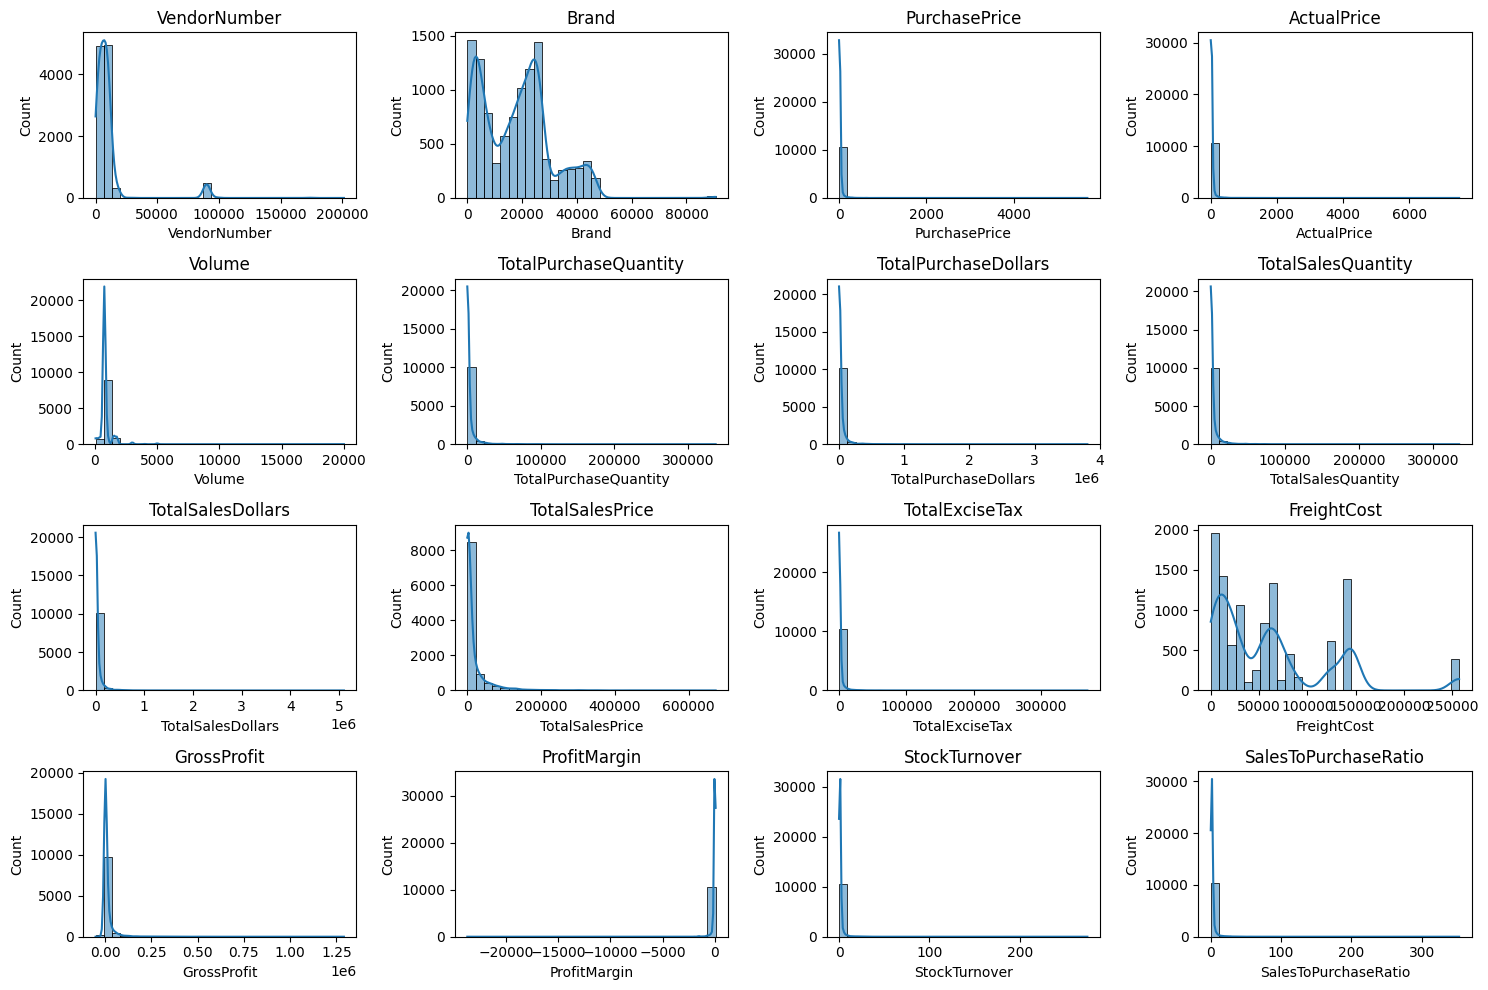

In [6]:
# use this code to visualize the distribution of multiple numerical columns in a dataset using histograms (with optional KDE lines)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Feature Distribution Insights & Issues

<table style="width:100%; border-collapse:collapse;">

<tr>
<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### 1️⃣ **GrossProfit**
- **Insight:**  
  Distribution is **right-skewed** — most values near 0, with outliers reaching **1.25M**.  
- **Problem:**  
  - Heavy outliers distort mean-based metrics.  
  - Affects regression models and clustering accuracy.  
- **Suggested Fix:**  
  Apply **log transformation** or **cap outliers** at upper percentiles.

</td>

<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

### 2️⃣ **ProfitMargin**
- **Insight:**  
  Originally **left-skewed** with extreme **negative margins** (as low as -20,000).  
- **Problem:**  
  - Logical bounds: typically **-100% ≤ margin ≤ 100%**.  
  - Negative extremes likely reflect **data entry errors** or **loss-heavy transactions**.  
- **Suggested Fix:**  
  Validate and **cap** at realistic domain thresholds.

</td>
</tr>

<tr>
<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

### 3️⃣ **StockTurnover**
- **Insight:**  
  Still **right-skewed**, most values within **0–10**, a few above **200**.  
- **Problem:**  
  - Outliers may stem from **vendor variability** or **data inconsistencies**.  
- **Suggested Fix:**  
  Use **winsorization** or **log transformation** to normalize scale.

</td>

<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### 4️⃣ **SalesToPurchaseRatio**
- **Insight:**  
  Similar to StockTurnover — clustered in **0–10**, outliers beyond **300**.  
- **Problem:**  
  - Expected ratio: roughly **1–5** under normal conditions.  
  - High ratios often due to **low purchase values** or **missing data**.  
- **Suggested Fix:**  
  Handle outliers or enforce **minimum purchase thresholds**.

</td>
</tr>
</table>

---

## <em>Key Takeaways</em>
- **GrossProfit** and **ProfitMargin** show skew and domain violations needing transformation or validation.  
- **StockTurnover** and **SalesToPurchaseRatio** contain long tails that can bias modeling results.  
- Post-cleaning, applying **log transforms** or **capping** will stabilize distributions for statistical modeling and ML preprocessing.


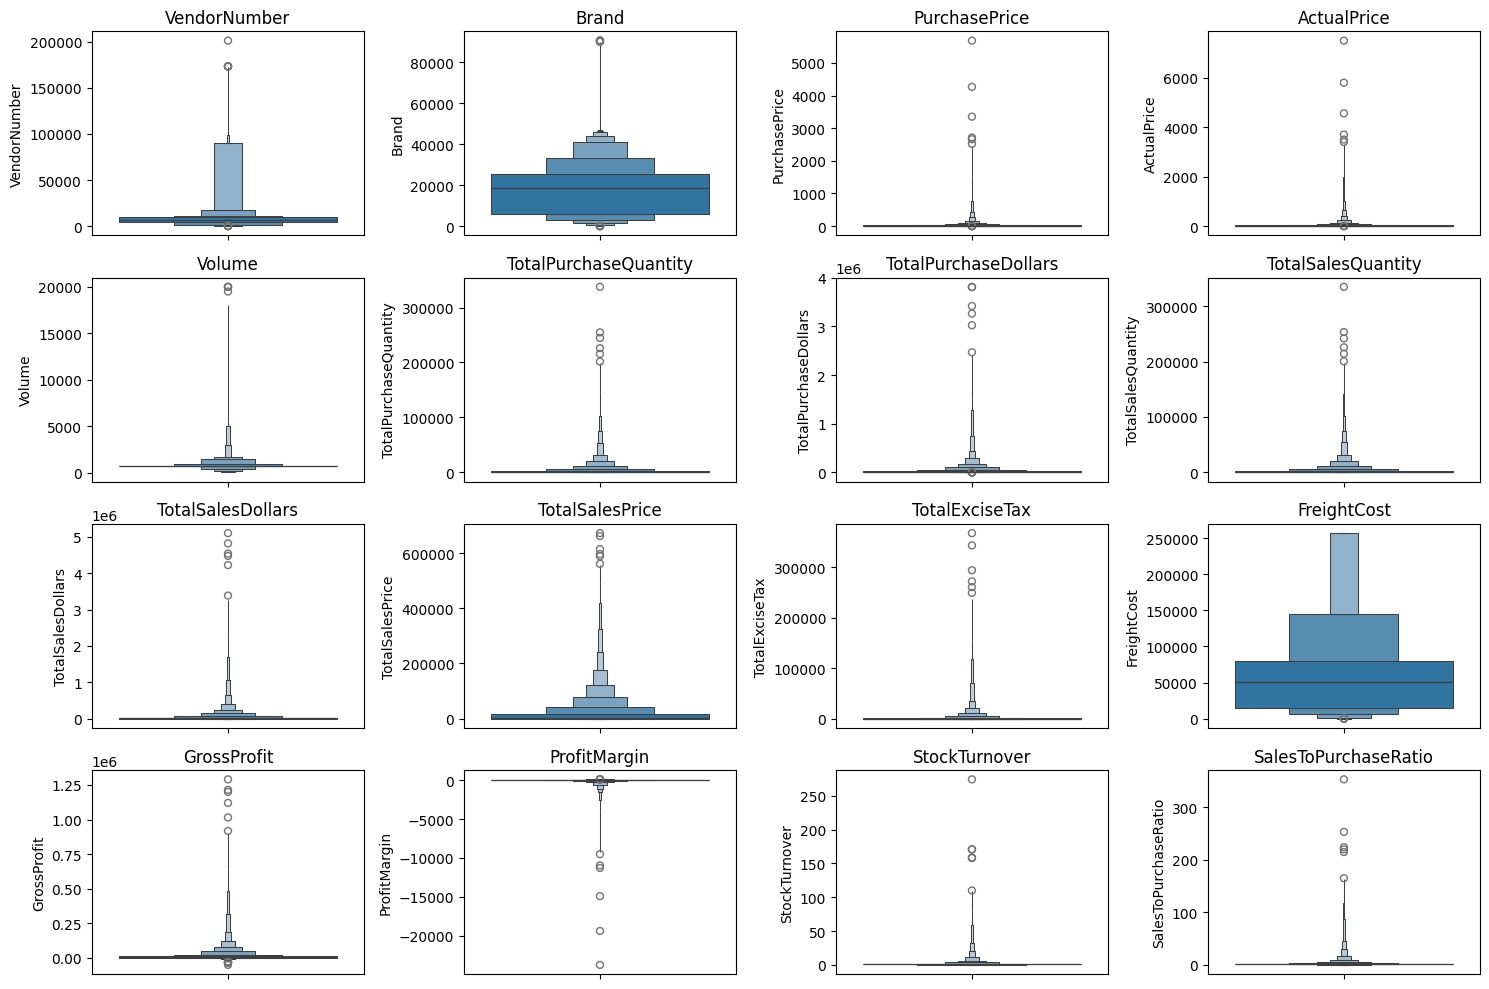

In [7]:
# Outlier Detection with BoxPlot 
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.boxenplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## Summary Statistics Insights

<table style="width:100%; border-collapse:collapse;">

<tr>
<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### ⚠️ **Negative & Zero Values**

#### **Gross Profit**
- **Min:** -52,002.78  
- **Insight:** Indicates potential losses — possibly due to **high purchase costs**, **discounting**, or **data entry errors**.  

#### **Profit Margin**
- **Min:** ~∞  
- **Insight:** Appears when **revenue is zero or negative**, meaning **costs exceed sales**.  

#### **Total Sales Quantity / Sales Dollars**
- **Min:** 0  
- **Insight:** Some products were **purchased but never sold**, suggesting **slow-moving or obsolete inventory**.  

</td>

<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

### 📊 **Outliers & High Variability**

#### **Purchase & Actual Prices**
- **Max:** 5,681.81 (Purchase), 7,499.99 (Actual)  
- **Mean:** 24.39 / 35.64  
- **Insight:** High disparity suggests **premium or high-value product categories**.  

#### **Freight Cost**
- **Range:** 0.09 → 257,032.07  
- **Insight:** Extreme variation points to **logistics inefficiencies** or **bulk shipment cases**.  

#### **Stock Turnover**
- **Range:** 0 → 274.5  
- **Insight:**  
  - **0:** Unsold stock  
  - **>1:** Indicates reuse of older stock  
  - **~274:** Exceptionally **fast-moving items**

</td>
</tr>
</table>

---

## <em>Key Takeaways</em>
- Dataset includes **loss-making** and **zero-revenue** entries → requires **data cleaning or flagging**.  
- **High standard deviations** across cost and freight metrics confirm **heavy-tailed distributions**.  
- **Stock turnover extremes** highlight the need for **differentiated inventory strategies** — either **clearance** or **restocking** focus.


In [8]:
# let's filter the data by removing inconsistencies 
df = pd.read_sql_query("""
    SELECT * FROM vendor_sales_summary
    WHERE GrossProfit > 0
    AND ProfitMargin > 0
    AND TotalSalesQuantity > 0""", conn)

##  Data Cleaning: SQL Filters Applied

The following SQL filters were used to remove **inconsistent or invalid entries** from the `vendor_sales_summary` table.

<table>
<tr>
<td style="vertical-align: top; width: 50%; padding-right: 20px;">

### 1️⃣ `GrossProfit > 0`
- **Purpose:** Removes rows where the vendor has **zero or negative gross profit**.  
- **Why:** Ensures profitability-related metrics remain meaningful by excluding loss-making or error-prone entries.  
- **Result:** Only transactions with positive gross returns are retained.

---

### 2️⃣ `ProfitMargin > 0`
- **Purpose:** Excludes rows with **zero or negative profit margins**.  
- **Why:** Prevents distortion caused by:
  - Items sold at a loss  
  - Missing or miscalculated margin data  
- **Result:** Keeps only valid and profitable records for margin-based analysis.

</td>
<td style="vertical-align: top; width: 50%; padding-left: 20px;">

### 3️⃣ `TotalSalesQuantity > 0`
- **Purpose:** Filters out entries with **no sales** or **negative sales quantities**.  
- **Why:** Maintains accuracy for key performance indicators such as:
  - **Sales-to-purchase ratios**  
  - **Stock turnover rates**  
  - **Demand forecasting metrics**  
- **Result:** Ensures all downstream KPIs are based on valid transactional data.

</td>
</tr>
</table>

---

## Summary
These filters collectively ensure that only **clean, consistent, and analytically reliable data** is included in the dataset — improving accuracy for:
- **Profitability analysis**
- **Sales performance metrics**
- **Predictive modeling and reporting**


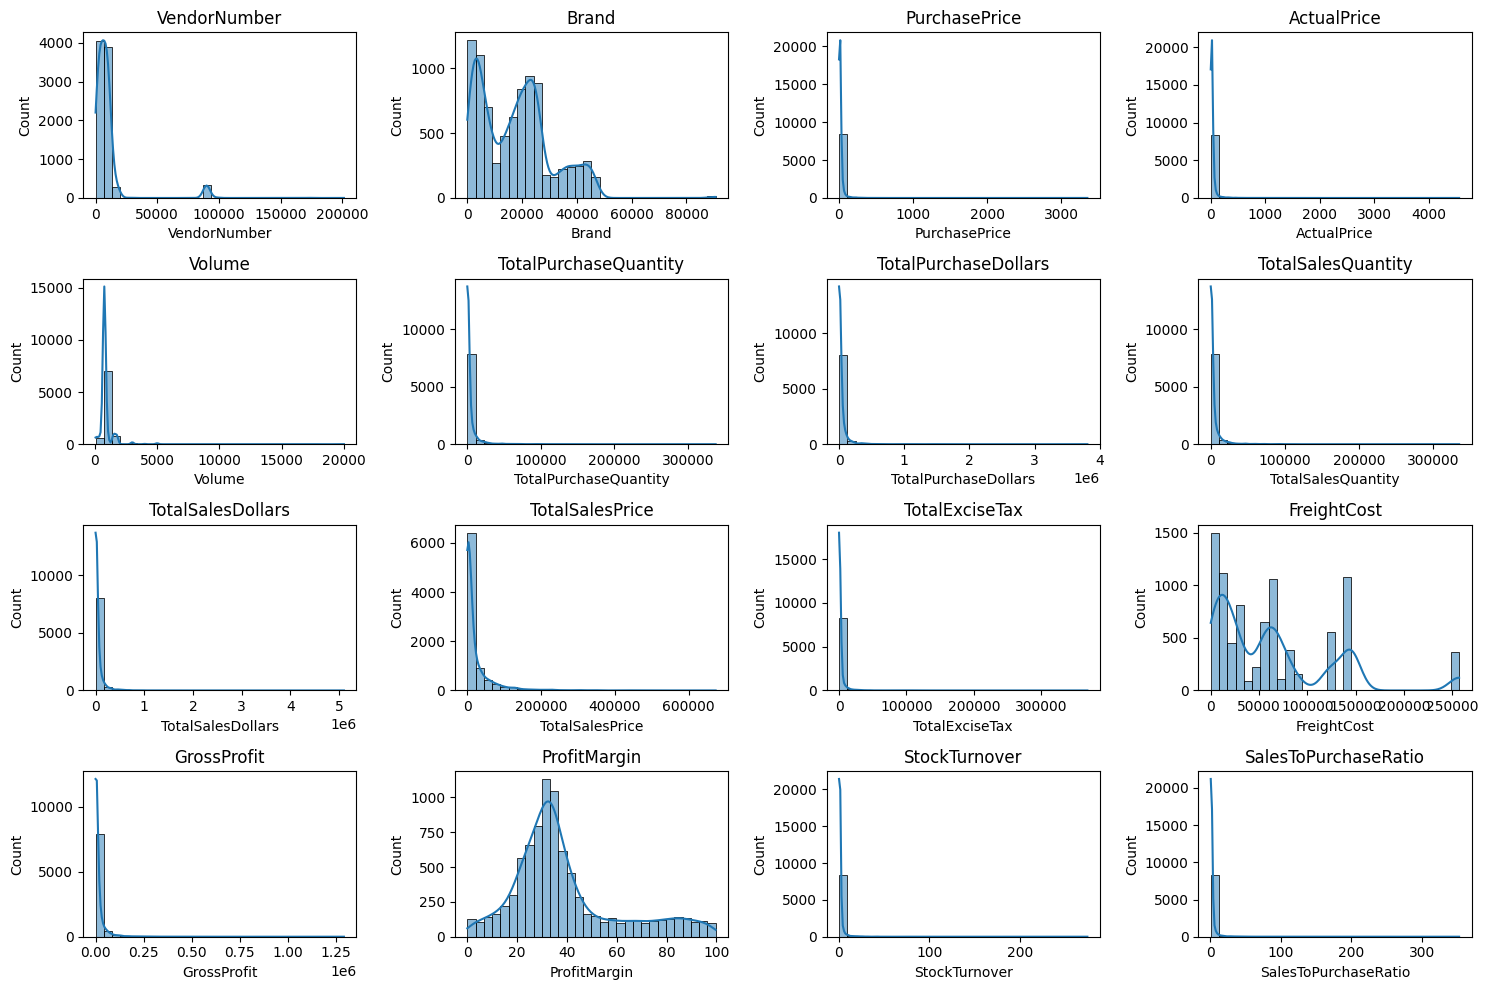

In [9]:
# Plot the distribution plot after cleaning the data 
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)  # 4x4 grid — adjust based on number of columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

## Post-Correction Insights on Numerical Features

<table>
<tr>
<td style="vertical-align: top; width: 50%; padding-right: 20px;">

### 1️⃣ **GrossProfit**
- **Distribution:** Still right-skewed, but more compact.  
- **Insight:** Extreme outliers likely capped or transformed (e.g., log-scaled).  
- **Improved:** Easier to model without rare large values dominating.  
- **Next Step:** Apply normalization for scale-sensitive models (KNN, SVM).

---

### 2️⃣ **ProfitMargin**
- **Distribution:** Nearly normal, centered around **30–40%**.  
- **Insight:** Negative outliers removed or corrected.  
- **Improved:** Ideal for ML models; no further cleaning required.  
- **Next Step:** Validate business logic (margin >100% or <0%).

</td>
<td style="vertical-align: top; width: 50%; padding-left: 20px;">

### 3️⃣ **StockTurnover**
- **Distribution:** Still right-skewed but much cleaner.  
- **Insight:** Most values under 10; long tail extends to 200+.  
- **Improved:** Outliers limited or handled effectively.  
- **Next Step:** Use log transformation to reduce remaining skew.

---

### 4️⃣ **SalesToPurchaseRatio**
- **Distribution:** Right-skewed with remaining long tail.  
- **Insight:** Majority between 0–10; few very high (~300+).  
- **Improved:** Better than before; extreme ratios still present.  
- **Next Step:** Cap high percentiles or flag anomalies.

</td>
</tr>
</table>

---

## Summary Table

| Column                   | Status        | Insights & Actions                                     |
|---------------------------|---------------|--------------------------------------------------------|
| **GrossProfit**           | Improved      | Still skewed; normalize for modeling.                  |
| **ProfitMargin**          | Ideal         | Cleaned and normally distributed.                      |
| **StockTurnover**         | Still skewed  | Long tail remains; log transform optional.             |
| **SalesToPurchaseRatio**  | Long tail     | Improved; cap or flag extreme values.                  |

---

## 💡 Final Thoughts
- The corrected data is now far more suitable for:
  - **Statistical analysis**
  - **Machine learning modeling**
  - **Business reporting**
- Remaining skewness in some variables can be addressed later depending on model sensitivity.

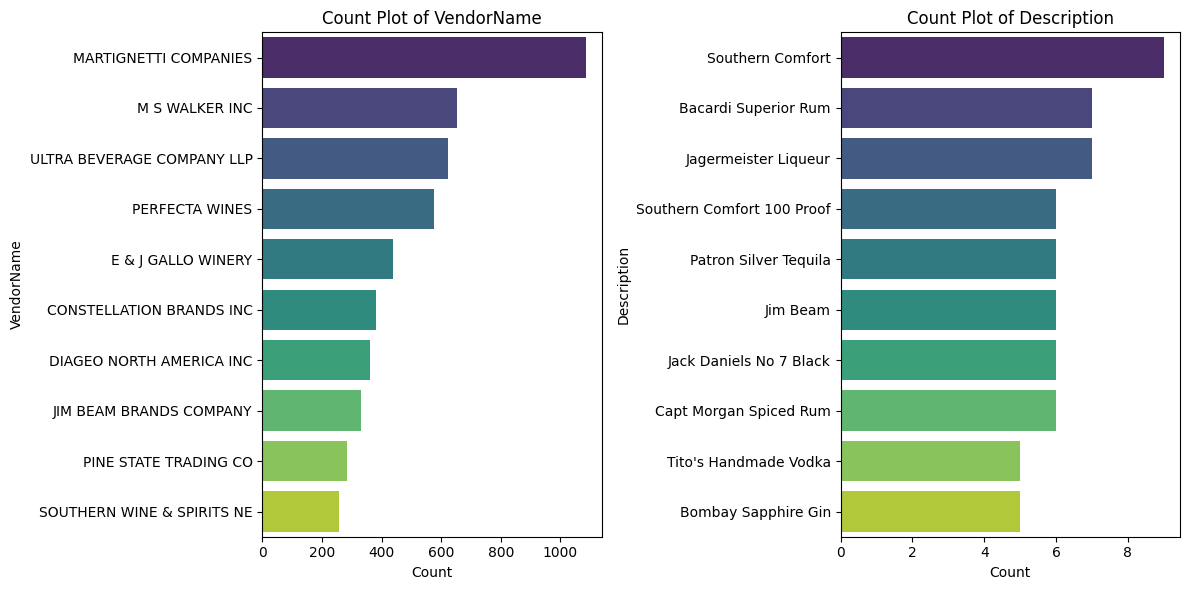

In [10]:
categorical_cols = ["VendorName", "Description"]
plt.figure(figsize=(12, 6))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)  # Adjust this if you have more than 2 columns
    sns.countplot(
        y=df[col],
        order=df[col].value_counts().index[:10],  # Top 10 categories
        palette="viridis"  # You can change this to "Set2", "pastel", etc.
    )
    plt.title(f"Count Plot of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Overview

The visualization displays the **top 10 most frequent values** for the categorical columns `VendorName` and `Description` using **horizontal count plots**.  
This comparison provides quick insights into the **most active suppliers** and **most popular products** in the dataset.

---
<table>
<tr>
<td style="vertical-align: top; width: 50%; padding-right: 20px;">

### **Top 10 Vendors**
- **Most frequent vendor:** `MARTIGNETTI COMPANIES`
- Other key vendors:
  - M S WALKER INC  
  - ULTRA BEVERAGE COMPANY LLP  
  - PERFECTA WINES  
- **Interpretation:**  
  Concentration among a few major vendors indicates strong supplier dominance and potential negotiation leverage.

</td>
<td style="vertical-align: top; width: 50%; padding-left: 20px;">

### **Top 10 Products**
- **Most popular product:** `Southern Comfort`
- Other high-frequency items:
  - Bacardi Superior Rum  
  - Jagermeister Liqueur  
  - Patron Silver Tequila  
- **Interpretation:**  
  These high-frequency SKUs are top contributors to sales volume, useful for demand forecasting and inventory optimization.

</td>
</tr>
</table>

---

## Key Insights
- The top vendors and products together account for a significant portion of total transactions, showing **high market concentration**.  
- Findings can guide:
  - **Procurement:** Identify critical suppliers and diversify risk.  
  - **Marketing:** Focus promotions on high-performing products.  
  - **Inventory Management:** Optimize stock levels based on recurring demand.  
- A long-tail pattern beyond the top 10 suggests **opportunities for product diversification** or targeted sales campaigns.

---
## Summary
This analysis highlights how vendor and product frequency distributions can reveal **supply chain dependencies**, **sales patterns**, and **inventory priorities** — forming a foundation for deeper profitability and forecasting analyses.

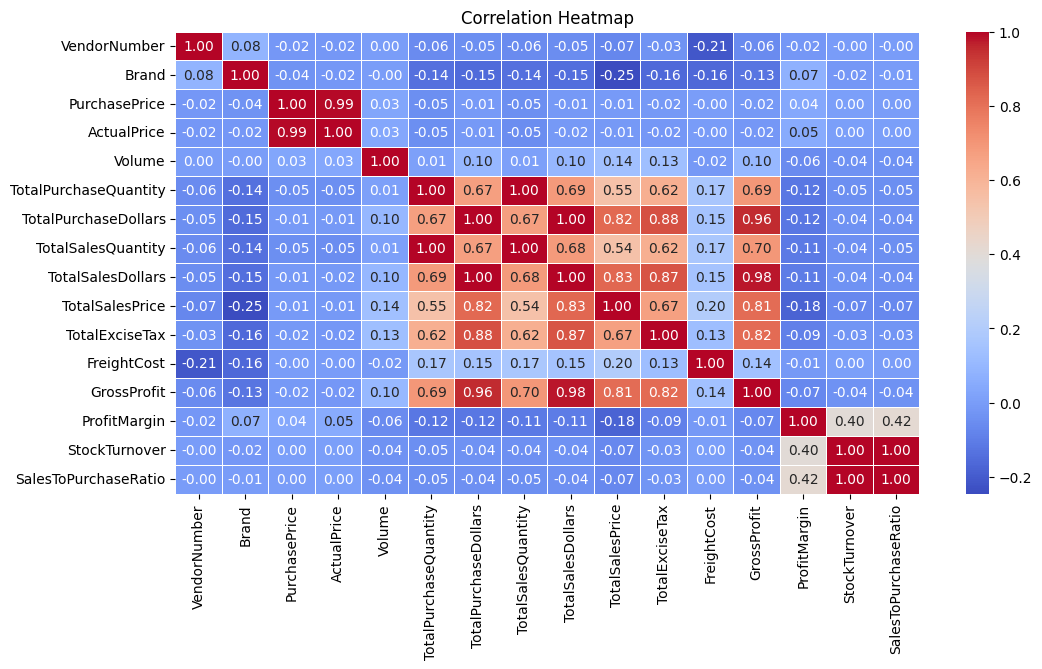

In [11]:
# ---- Correlation HeatMap ----
plt.figure(figsize=(12, 6))
correlation_matrix = df[numerical_cols].corr() 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Correlation Insights

<table style="width:100%; border-collapse:collapse;">

<tr>
<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### 📈 **Key Findings**

#### **Purchase Price Relationships**
- Weak correlation with **TotalSalesDollars** (-0.012)  
- Weak correlation with **GrossProfit** (-0.016)  
- **Interpretation:** Price changes have **minimal impact** on sales or profit.  

#### **Inventory Efficiency**
- Very strong correlation (**0.999**) between **TotalPurchaseQuantity** & **TotalSalesQuantity**  
- **Interpretation:** Indicates **near-perfect inventory turnover** — purchases match sales closely.  

</td>

<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

#### **Profit Margin Dynamics**
- Negative correlation (**-0.179**) with **TotalSalesPrice**  
- **Interpretation:** Higher sales prices correlate with **lower margins** — likely due to **competitive pricing**.  

#### **Stock Turnover Impact**
- Weak negative correlation with **GrossProfit (-0.038)**  
- Weak negative correlation with **ProfitMargin (-0.055)**  
- **Interpretation:** Faster turnover **doesn’t guarantee higher profitability**; may involve **discount-driven sales**.  

</td>
</tr>

<tr>
<td colspan="2" style="background-color:#f8f9fa; padding:15px; border-radius:10px;">

### **Suggested Actions**
1. Re-evaluate **pricing strategies** for high-priced, low-margin products.  
2. Maintain **efficient inventory alignment** between purchases and sales.  
3. Analyze **high-turnover items** to identify if discounts or operational costs suppress profits.  

</td>
</tr>
</table>


### Data Analysis - Bussiness Problem

### Business Problem 1: Identify Underperforming Brands with High Profit Margins

#### **Objective**:
Identify brands that require promotional or pricing adjustments due to:
- **Low sales performance** (underperforming in market penetration)
- **High profit margins** (indicating pricing power or cost efficiency)

In [12]:
# Brand Performance Analysis
# ---- Group data by product Description to analyze brand performance metrics ----
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',       # Calculate total sales revenue per brand
    'ProfitMargin':'mean'            # Calculate average profit margin per brand
}).reset_index()                

# Resulting DataFrame contains:
# - Description: Brand/product names
# - TotalSalesDollars: Cumulative sales for each brand
# - ProfitMargin: Average margin percentage for each brand

In [13]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85) 

In [14]:
low_sales_threshold

560.299

In [15]:
high_margin_threshold

64.97017552750111

In [16]:
# filter brands with low sales but high profit margins 
# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] < low_sales_threshold) &
    (brand_performance['ProfitMargin'] > high_margin_threshold)
] 
print("Brands with low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [17]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000] # for better visualization

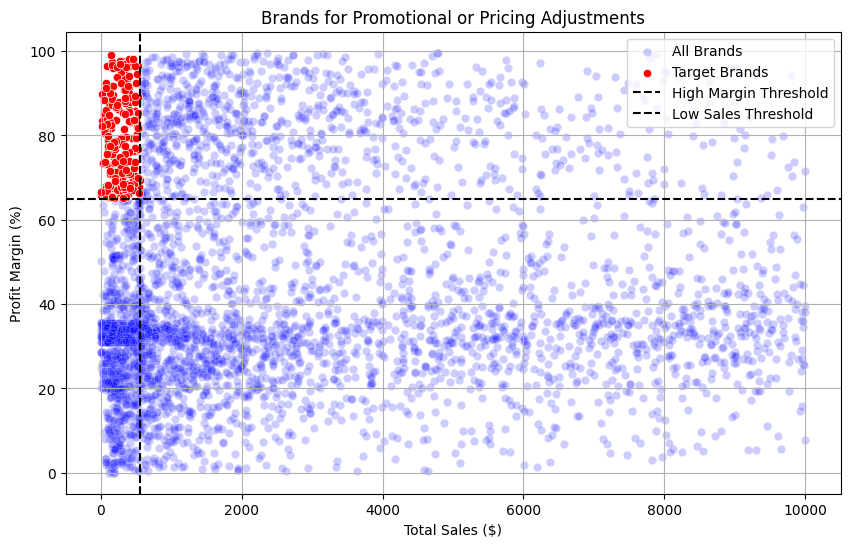

In [18]:
plt.figure(figsize=(10, 6))

# --- All brands (blue, transparent) ---
sns.scatterplot(
    data=brand_performance, 
    x='TotalSalesDollars', 
    y='ProfitMargin', 
    color="blue", 
    label="All Brands", 
    alpha=0.2
)

# --- Target brands (red) ---
sns.scatterplot(
    data=target_brands, 
    x='TotalSalesDollars', 
    y='ProfitMargin', 
    color="red", 
    label="Target Brands"
)

# --- Threshold lines ---
plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

# --- Labels and formatting ---
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

## Brand Performance Analysis for Strategic Decisions

This scatter plot visualizes **brand performance** based on **Total Sales Dollars** (x-axis) and **Profit Margin (%)** (y-axis):

- 🔵 **All Brands**: Displayed in transparent blue, these show the overall distribution of brands. Most are clustered in low-to-moderate sales and profit margins.
  
- 🔴 **Target Brands**: Highlighted in red, these are the specific brands selected for further review. They likely fall into regions of  <em>low sales but high margins</em> or <em>other strategic thresholds</em>.

- ⚫ **Threshold Lines**:
  - **Horizontal Line** = High Margin Threshold: Brands above this line have strong profit margins.
  - **Vertical Line** = Low Sales Threshold: Brands to the left of this line have low sales performance.

---

### Insights:
- Brands in the **top-left quadrant** (low sales, high margin) may benefit from **promotional efforts** to boost sales.
- Brands in the **bottom-right** (high sales, low margin) might need **pricing adjustments** or **cost optimization**.
- This visualization helps prioritize actions for **pricing strategy**, **promotion**, or **portfolio adjustments**.


### Business Problem 2: Identify Top-Performing Vendors and Brands

#### **Objective**:
Identify which vendors and brands demonstrate:
- Highest sales volume (quantity)
- Highest revenue generation (dollar value)
- Strongest market performance

In [19]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [20]:
# top vendor and Bands by sales performance 
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

In [21]:
top_brands.apply(lambda x: format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

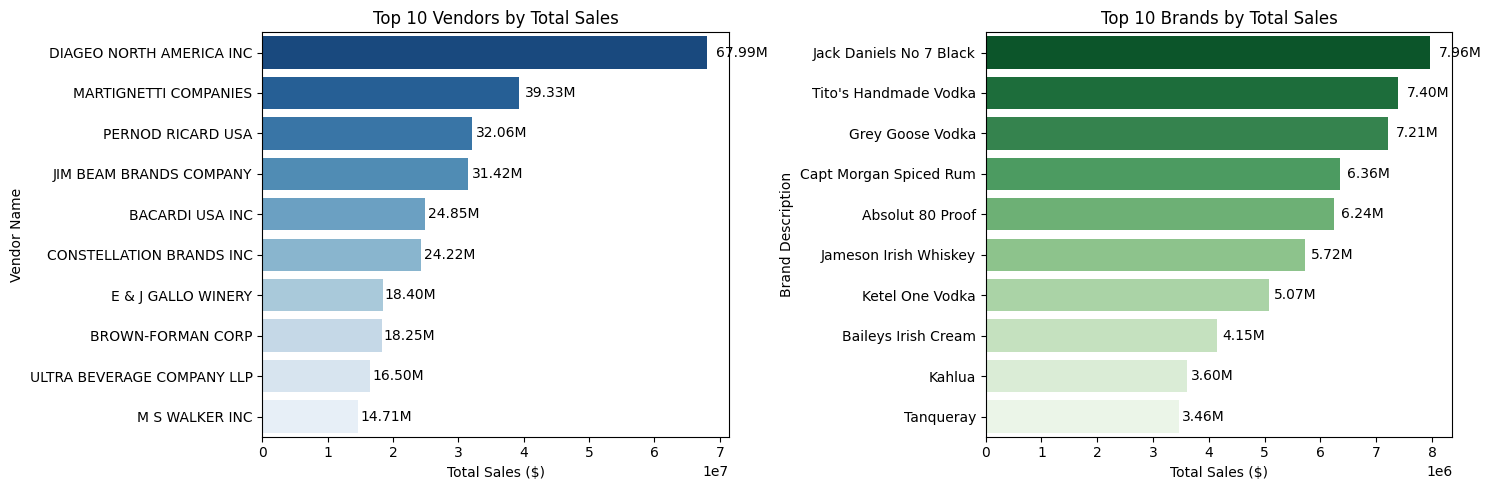

In [22]:
plt.figure(figsize=(15, 5))

# --- Plot for Top Vendors ---
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Total Sales")
plt.xlabel("Total Sales ($)")
plt.ylabel("Vendor Name")

# --- Add labels on bars ---
for bar in ax1.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax1.text(
        width + (width * 0.02),
        y_pos,
        format_dollars(width),
        ha='left', va='center', fontsize=10, color='black'
    )

# --- Plot for Top Brands ---
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index, x=top_brands.values, palette="Greens_r")
plt.title("Top 10 Brands by Total Sales")
plt.xlabel("Total Sales ($)")
plt.ylabel("Brand Description")

# --- Add labels on bars ---
for bar in ax2.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax2.text(
        width + (width * 0.02),
        y_pos,
        format_dollars(width),
        ha='left', va='center', fontsize=10, color='black'
    )

# --- Final layout --- 
plt.tight_layout()
plt.show()

### Business Problem 3: Which vendors contribute the most to total purchase dollar?

In [23]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': sum, 
    'GrossProfit': sum, 
    'TotalSalesDollars': sum 
}).reset_index()
vendor_performance.shape  # we have 119 vendors 

(119, 4)

In [24]:
# How much the contribution of each vendor towards purchase 
vendor_performance['Purchase_Contribution%'] = vendor_performance['TotalPurchaseDollars'] / vendor_performance['TotalPurchaseDollars'].sum()*100

In [25]:
vendor_performance = round(vendor_performance.sort_values('Purchase_Contribution%', ascending= False), 2)

In [26]:
# Get top 10 vendors
top_vendors = vendor_performance.head(10)

top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [27]:
top_vendors['Purchase_Contribution%'].sum()

65.69000000000001

In [28]:
top_vendors['Cumulative_Contribution%'] = top_vendors['Purchase_Contribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


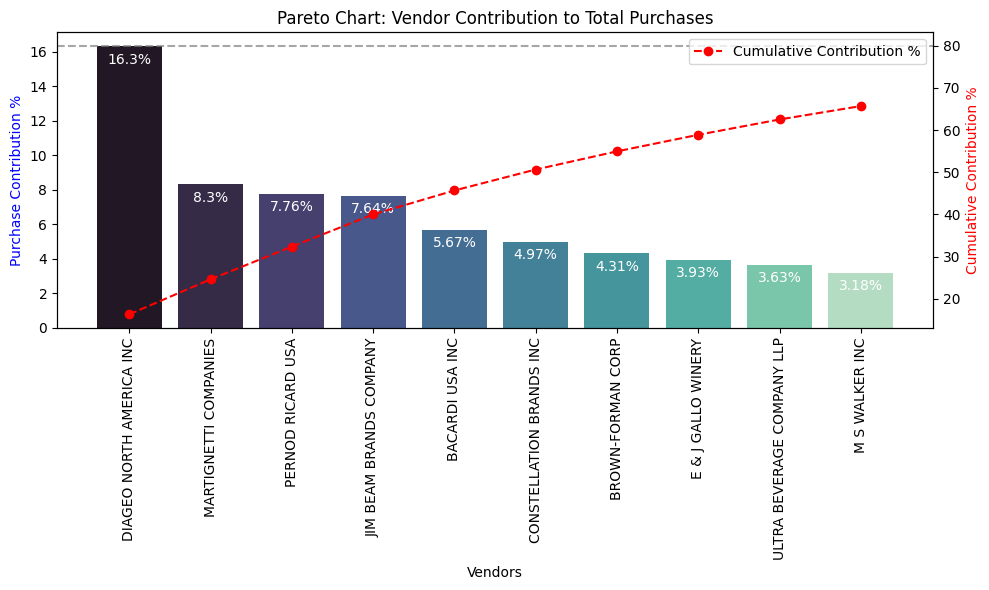

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# ---- Bar plot for Purchase Contribution % ----
sns.barplot(
    x=top_vendors['VendorName'],
    y=top_vendors['Purchase_Contribution%'],
    palette="mako",
    ax=ax1
)

# ---- Add value labels on bars ----
for i, value in enumerate(top_vendors['Purchase_Contribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# ---- Create secondary axis for cumulative % line ----
ax2 = ax1.twinx()
ax2.plot(
    top_vendors['VendorName'],
    top_vendors['Cumulative_Contribution%'],
    color='red',
    marker='o',
    linestyle='dashed',
    label='Cumulative Contribution %'
)

# ---- Customize axes and labels ----
ax1.tick_params(axis='x', rotation=90)  # Fix rotation properly
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# ---- Add horizontal line at 80% to mark Pareto threshold ----
ax2.axhline(y=80, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Business Problem 4: How much of total procurement is dependent on the top vendors ?

In [30]:
print(f"Total Purchase Contribution of top 10 vendor is {round(top_vendors['Purchase_Contribution%'].sum(),2)} %")

Total Purchase Contribution of top 10 vendor is 65.69 %


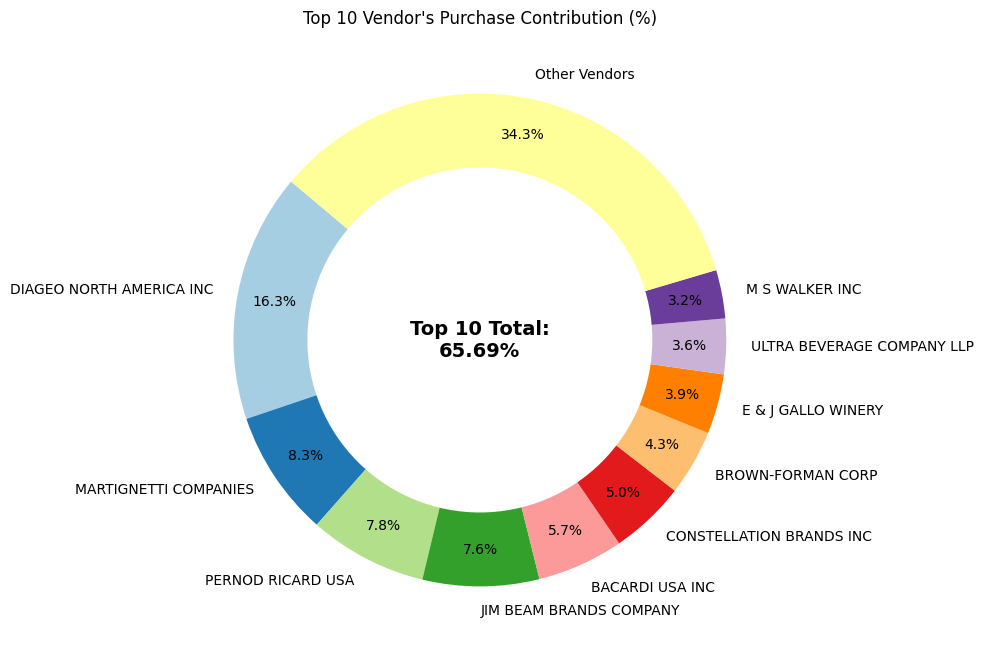

In [31]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['Purchase_Contribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# ---- Append "Other Vendors" category ----
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# ---- Donut Chart ----
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# ---- Draw a white circle in the center to create a "donut" effect ----
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# ---- Add Total Contribution annotation in the center ----
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold',
         ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

### Business Problem 5: Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings ?

In [32]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [33]:
df["OrderSize"] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])

In [34]:
df[["OrderSize", "TotalPurchaseQuantity"]].head()

,OrderSize,TotalPurchaseQuantity
0,Large,145080
1,Large,164038
2,Large,187407
3,Large,201682
4,Large,138109


In [35]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.057543
Medium,15.486414
Large,10.777625


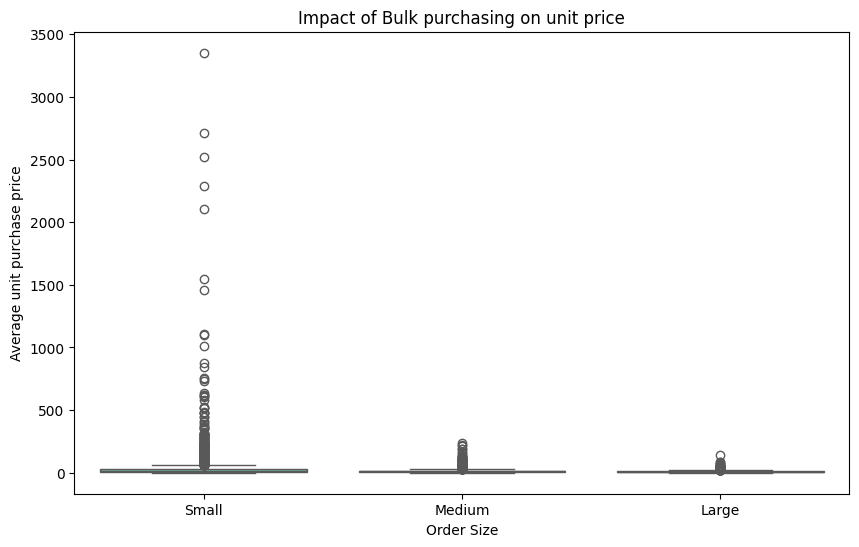

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette='Set2')
plt.title("Impact of Bulk purchasing on unit price")
plt.xlabel("Order Size")
plt.ylabel("Average unit purchase price")
plt.show()

<li>Vendor buying in bulk(large order size) get the lowest unit price($10.78 per unit), meaning higher margins if they can manage inventory efficiently.</li>
<li>The Price between small and large order is substanial (~72% reduction in unit cost)</li>
<li>This suggests that bulk pricing strategies successfully vendors to purchase in larger volumes, leading to higher overall sales despite lower per unit revenue.</li>

### Business Problem 6: Which vendor have low inventory turnover, including excess stock and slow-moving products

In [37]:
df[df['StockTurnover'] < 1]\
  .groupby('VendorName')[['StockTurnover']]\
  .mean()\
  .sort_values(by='StockTurnover', ascending=True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


### Business Problem 7: How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [38]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))


Total Unsold Capital: 2.71M


### Business Problem 8: What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors 

In [39]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)


In [40]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [41]:
top_vendors

0       25.297693
1       21.062810
2       24.675786
3       27.139908
4       28.412764
          ...    
3523    79.684817
3681    85.782102
4751    93.085860
4920    95.012530
5050    94.271857
Name: ProfitMargin, Length: 2142, dtype: float64

In [42]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


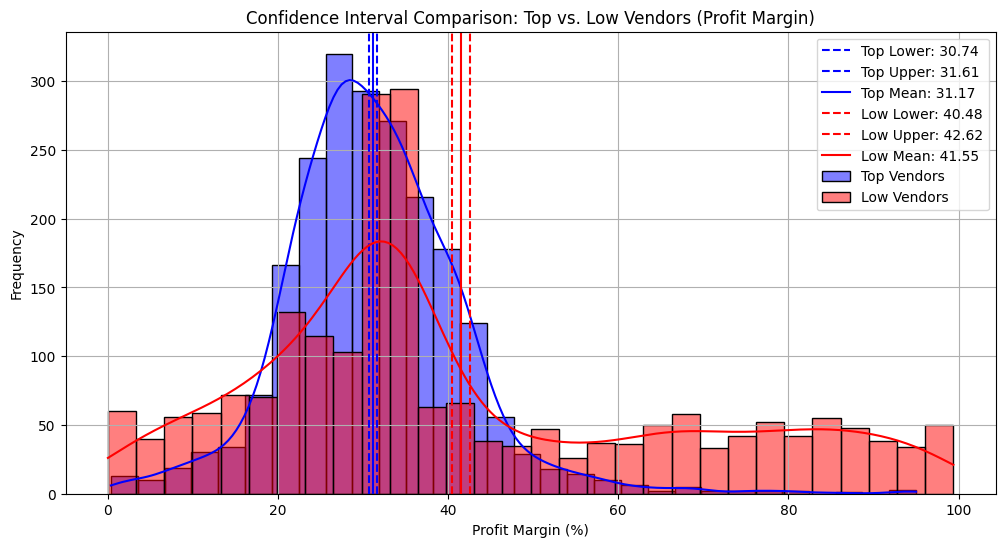

In [43]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# ---- Top Vendors Plot ----
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# ---- Low Vendors Plot ----
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# ---- Finalize Plot ----
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

## Key Insights on Vendor Performance and Margins

<table style="width:100%; border-collapse:collapse;">

<tr>

<!-- LEFT COLUMN -->
<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### 1️⃣ **Confidence Intervals Comparison**
- **Low-Performing Vendors:** 40.48% → 42.62%  
- **Top-Performing Vendors:** 30.74% → 31.61%  
- **Insight:**  
  Low performers exhibit **higher average profit margins**, even with lower sales volume.

</td>

<!-- RIGHT COLUMN -->
<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

### 2️⃣ **Interpretation**
- Vendors with **lower sales volumes** tend to sustain **higher Biofit margins**, likely because of:  
  - **Premium product pricing**  
  - **Lower operational costs** or niche-market focus  
  - **Selective clientele** with higher willingness to pay  

</td>
</tr>

<tr>
<td style="vertical-align: top; width: 50%; background-color:#ffffff; padding:15px; border-radius:10px;">

### 3️⃣ **Recommendations for High-Performing Vendors**
*(Focus: Profitability Improvement)*  
- Apply **selective price increases** on high-demand SKUs.  
- Improve **cost efficiency** across operations and logistics.  
- Introduce **bundling / combo offers** to raise transaction value.  

</td>

<td style="vertical-align: top; width: 50%; background-color:#f8f9fa; padding:15px; border-radius:10px;">

### 4️⃣ **Recommendations for Low-Performing Vendors**
*(Focus: Volume Growth)*  
- Strengthen **marketing and brand reach** to boost visibility.  
- Introduce **competitive pricing** to drive higher sales volumes.  
- Expand **distribution networks** for wider availability.  

</td>
</tr>
</table>

---

## <em>Summary Takeaway</em>
- **Inverse correlation** between sales volume and profit margin observed.  
- **Low performers:** Margin-rich but volume-poor.  
- **Top performers:** High revenue, lower margins due to pricing pressure.  
- A **balanced strategy** combining **pricing optimization** and **volume expansion** will maximize profitability.


<center>

<div style="font-family: 'Times New Roman', Times, serif; font-size: 16px; padding: 12px;">
    Made with <span style="color: #e25555;">❤️</span> by <strong>Faisal Khan</strong><br>
    <span style="color: gray; font-size: 13px;">Powered by Jupyter Notebook</span>
</div>

</center>


In [2]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook
with open("3_Analysis.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Convert notebook to HTML
html_exporter = HTMLExporter(template_name="classic")
body, _ = html_exporter.from_notebook_node(nb)

# Save HTML output
with open("performance-Analysis.html", "w", encoding="utf-8") as f:
    f.write(body)